In [425]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
base_path = Path('/content/drive/MyDrive') # change path here!

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

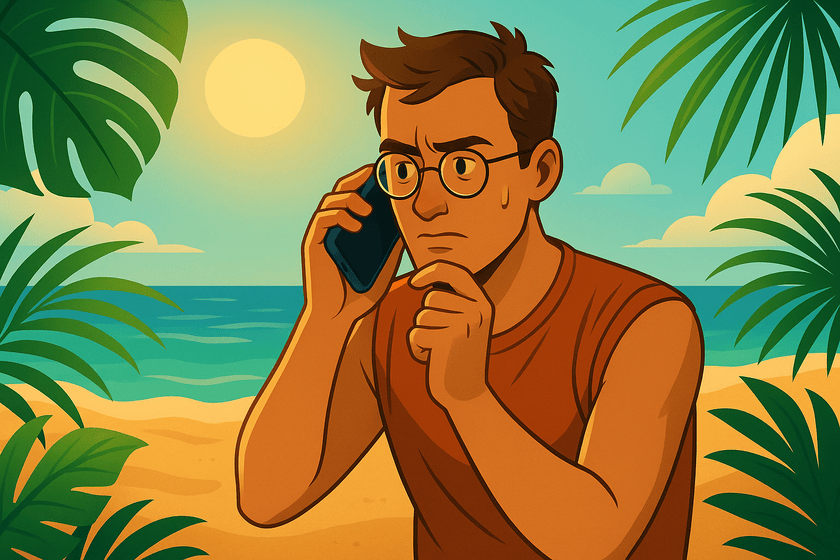

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [427]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

# Data overview and analysis

In [428]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      793 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [429]:
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,793.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,33.123938
std,0.486592,0.836071,14.526497,1.102743,0.806057,51.578312
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [430]:
titanic_df.isna().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,98
Cabin,687


In [431]:
titanic_df['Sex'] = titanic_df['Sex'].map({'male' : 0, 'female' : 1})
titanic_df['FamilySize'] = pd.cut(titanic_df['SibSp'] + titanic_df['Parch'] + 1, [0, 2, 4, float('inf')], labels=['Alone', 'Small', 'Large'], right=False)
titanic_df['IsKnownCabin'] = ~titanic_df['Cabin'].isna()
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])
titanic_df['Fare'] = titanic_df.groupby(['Pclass'])['Fare'].transform(lambda x: x.fillna(x.median()))
titanic_df['Age'] = titanic_df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
titanic_df = titanic_df.drop(columns=['SibSp', 'Parch', 'Name', 'Cabin', 'Ticket'])
titanic_df['Fare'] = np.log1p(titanic_df['Fare'])
#titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=[0, 18, 35, 60, float('inf')], labels=['Child', 'YoungAdult', 'Adult', 'Senior']) # okazalo sie to miec male znaczenie
titanic_df['IsChild'] = titanic_df['Age'] < 18

In [432]:
titanic_df_copy = pd.get_dummies(titanic_df, columns=['Pclass', 'Embarked', 'FamilySize'])

<Axes: >

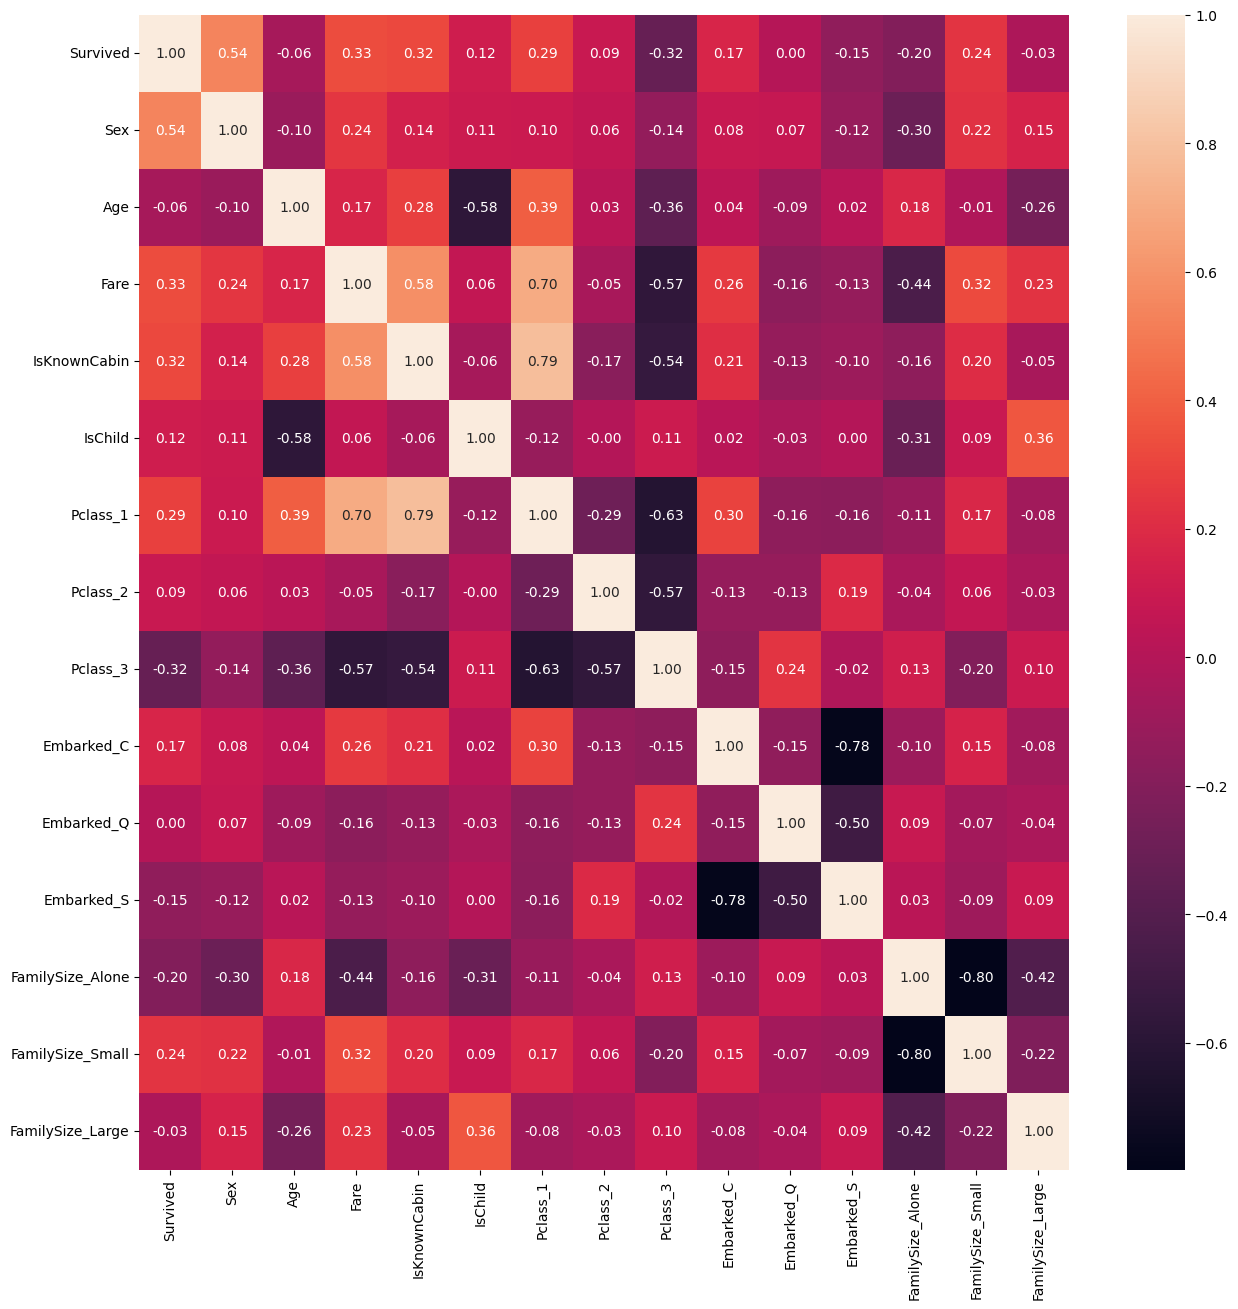

In [433]:
plt.figure(figsize=(15, 15))
sns.heatmap(titanic_df_copy.corr(), annot=True, fmt = '.2f')

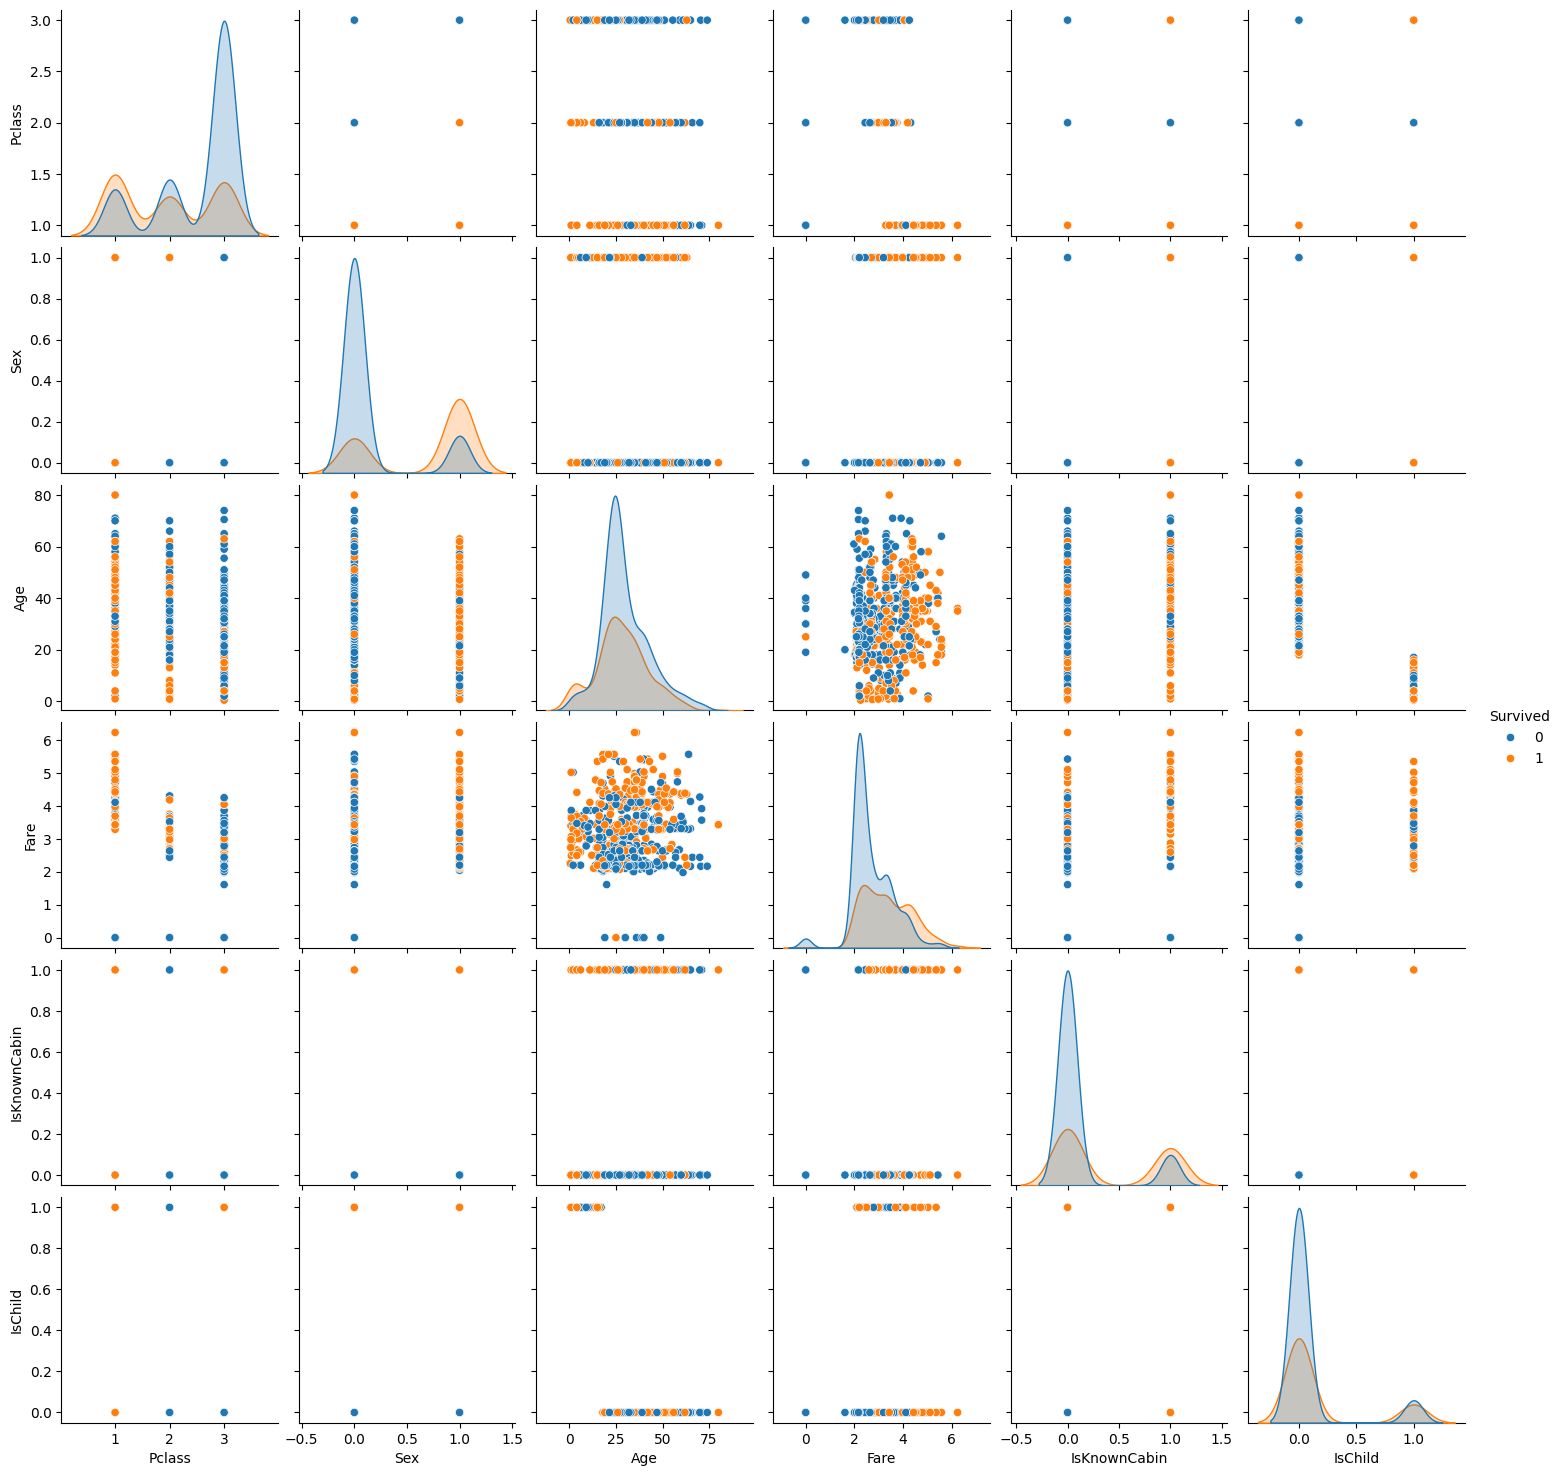

In [434]:
sns.pairplot(titanic_df, hue='Survived')

In [435]:
titanic_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsKnownCabin,IsChild
PassengerId,,,,,,,,,
1,0,3,0,22.0,2.110213,S,Small,False,False
2,1,1,1,38.0,4.280593,C,Small,True,False
3,1,3,1,26.0,2.188856,S,Alone,False,False
4,1,1,1,35.0,3.990834,S,Small,True,False
5,0,3,0,35.0,2.202765,S,Alone,False,False


In [436]:
titanic_df = titanic_df.drop(columns = ['Age'])
df = pd.get_dummies(titanic_df, columns=['Embarked', 'FamilySize', 'Pclass'])

Wnioski:

Survived najbardziej zalezy od kolumn Sex, Fare, IsKnownCabin, Pclass, FamilySize.
Widac tez powiazanie z kolumna Embarked. W kolumnie age jest niewielkie powiązanie z przeżywalnoscią, gdy analizuje się dzieci.

In [437]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [438]:
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, shuffle=True)

# Dummy Classifier

In [439]:
from sklearn.dummy import DummyClassifier

In [440]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       103
           1       0.47      0.53      0.49        76

    accuracy                           0.54       179
   macro avg       0.54      0.54      0.54       179
weighted avg       0.55      0.54      0.54       179



array([[57, 46],
       [36, 40]])

# Decision Tree Classifier

In [441]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [442]:
tree_model = DecisionTreeClassifier(max_depth=5)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       103
           1       0.92      0.61      0.73        76

    accuracy                           0.81       179
   macro avg       0.84      0.78      0.79       179
weighted avg       0.83      0.81      0.80       179



array([[99,  4],
       [30, 46]])

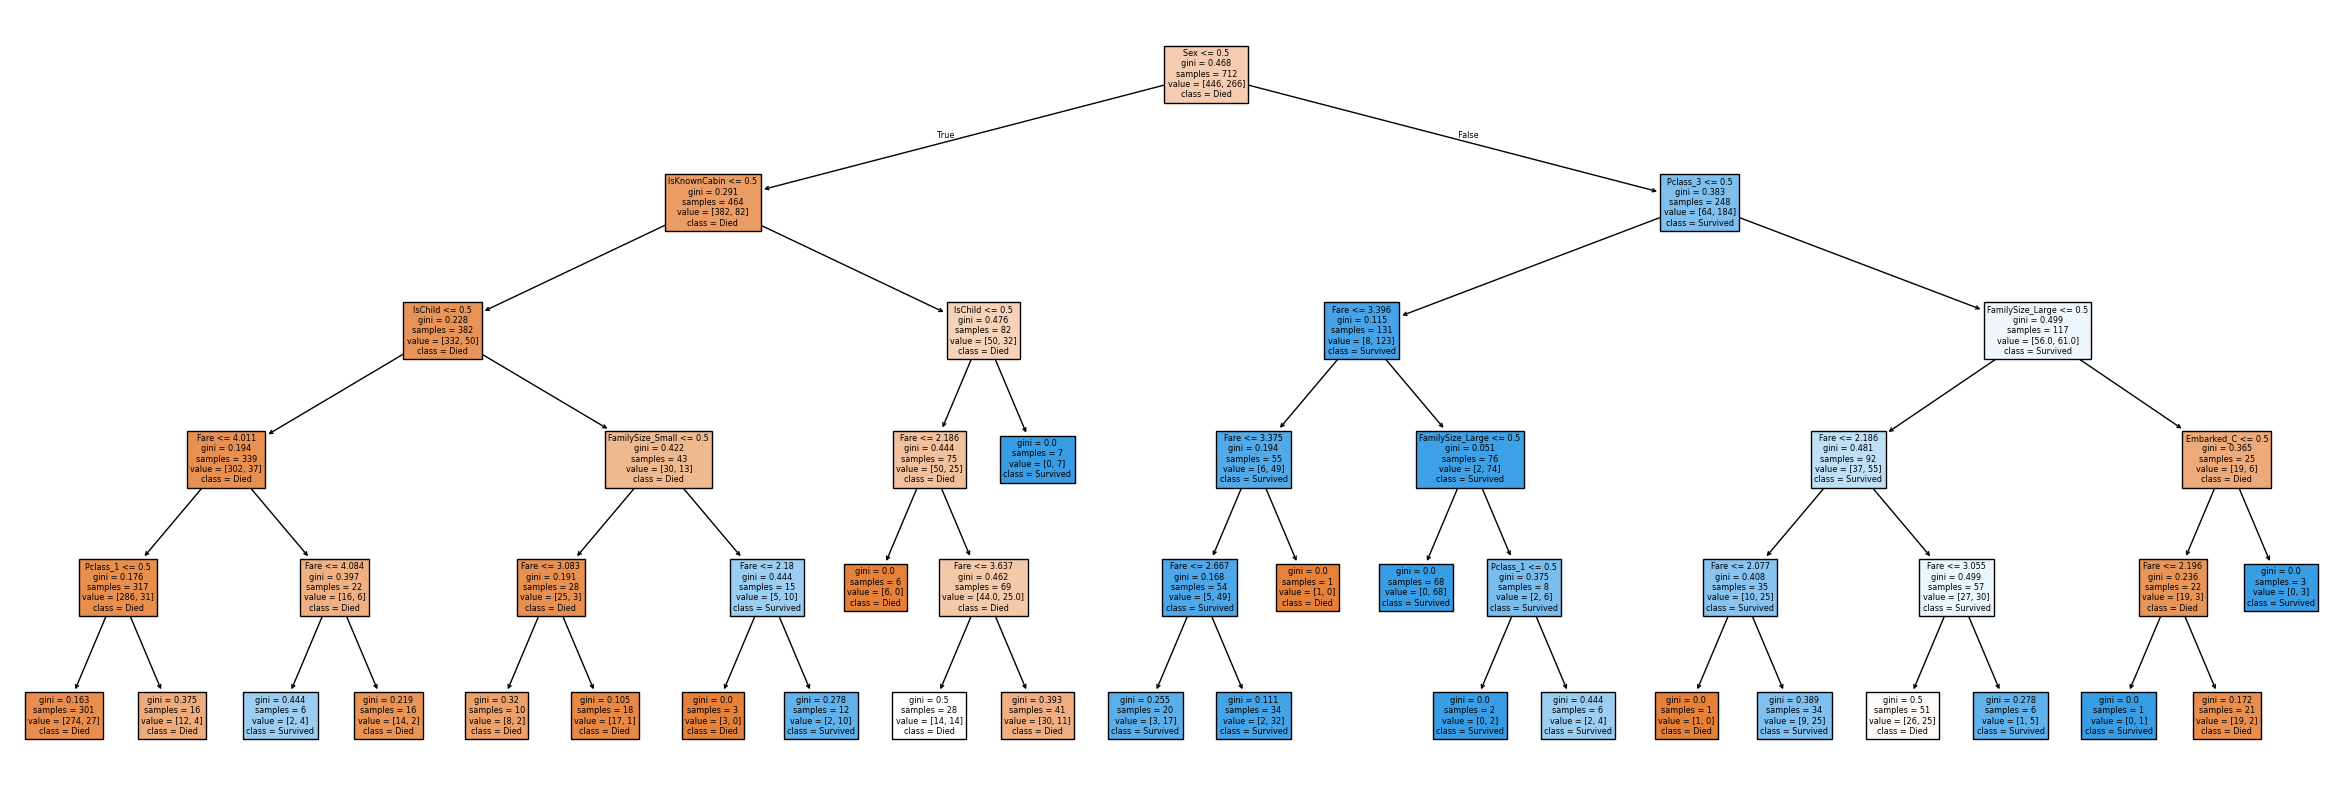

In [443]:
plt.figure(figsize=(30, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['Died', 'Survived'], filled=True)
plt.show()

# SVM

In [444]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [445]:
df.head()

,Survived,Sex,Fare,IsKnownCabin,IsChild,Embarked_C,Embarked_Q,Embarked_S,FamilySize_Alone,FamilySize_Small,FamilySize_Large,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,
1,0,0,2.110213,False,False,False,False,True,False,True,False,False,False,True
2,1,1,4.280593,True,False,True,False,False,False,True,False,True,False,False
3,1,1,2.188856,False,False,False,False,True,True,False,False,False,False,True
4,1,1,3.990834,True,False,False,False,True,False,True,False,True,False,False
5,0,0,2.202765,False,False,False,False,True,True,False,False,False,False,True


In [446]:
numeric_features = ['Fare', ]
binary_features = ['Sex', 'IsKnownCabin', 'IsChild']
categorical_features = ['Pclass', 'Embarked', 'FamilySize']

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

In [447]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])

In [448]:
y_pred = svm_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       103
           1       0.82      0.67      0.74        76

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



array([[92, 11],
       [25, 51]])

# Random Forest Classifier

In [449]:
from sklearn.ensemble import RandomForestClassifier

In [450]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10)

In [451]:
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       103
           1       0.90      0.68      0.78        76

    accuracy                           0.83       179
   macro avg       0.85      0.81      0.82       179
weighted avg       0.84      0.83      0.83       179



array([[97,  6],
       [24, 52]])

Wszystkie te modele radzą sobie całkiem dobrze. Rzeczą, którą można zauważyć w większości przypadków jest znacznie częstsze występowanie wyniku False Negative niż False Positive.

# Analiza hiperparametrów Decision Tree Classifier

In [452]:
from sklearn.metrics import accuracy_score

Badane hiperparametry: max_depth, min_samples_leafs

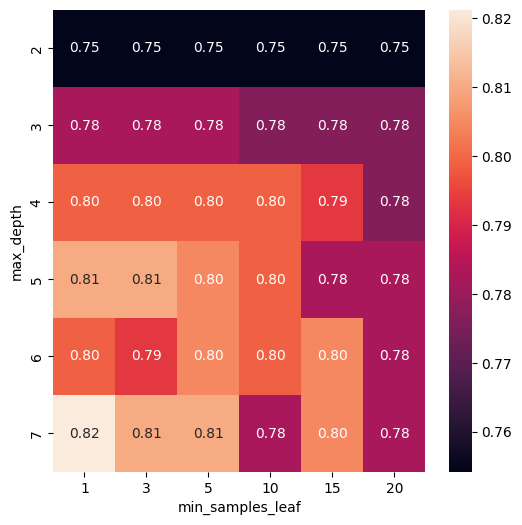

In [453]:
max_depths = [2, 3, 4, 5, 6, 7]
min_samples_leafs = [1, 3, 5, 10, 15, 20]

results = np.zeros((len(max_depths), len(min_samples_leafs)))

for i, depth in enumerate(max_depths):
  for j, min_leaf in enumerate(min_samples_leafs):
    model = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_leaf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[i, j] = accuracy_score(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(results, annot=True, fmt='.2f', xticklabels=min_samples_leafs, yticklabels=max_depths)
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.show()


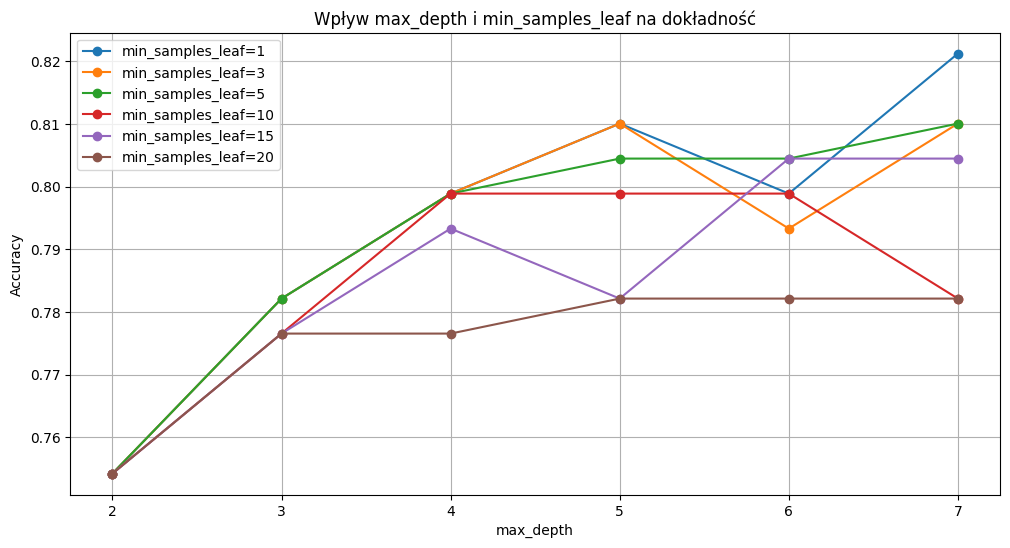

In [454]:
plt.figure(figsize=(12, 6))

for j, min_leaf in enumerate(min_samples_leafs):
    plt.plot(
        max_depths,
        results[:, j],
        label=f"min_samples_leaf={min_leaf}",
        marker='o'
    )

plt.title("Wpływ max_depth i min_samples_leaf na dokładność")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

Wnioski:

Dla max_depth najlepsze jest 5-6, poza tym przedziałem obserwuje sie overfitting i underfitting.

Dla drzew plytkich max_depth < 3, znaczenie min_samples_leaf jest niewielkie, ale wzrasta wraz ze wzrostem max_depth.

Najlepszym wyborem jest max_depth = 5 i min_samples_leaf = 1 lub 5

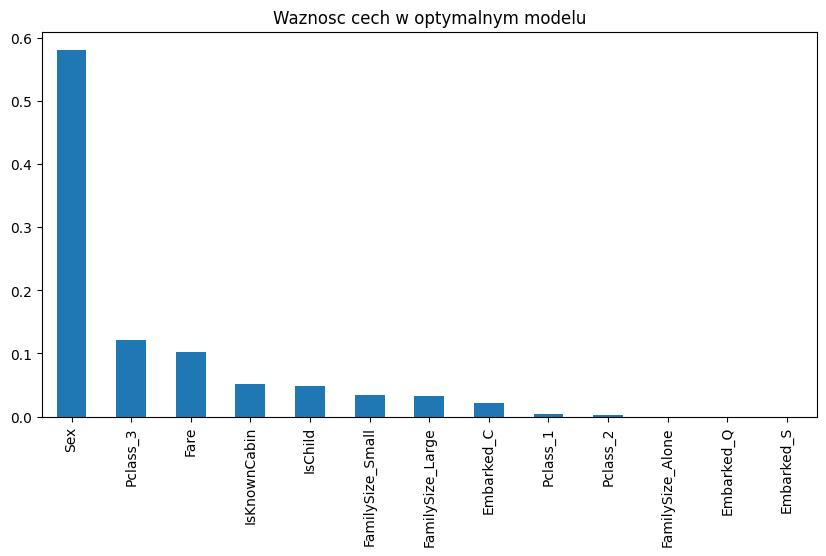

In [455]:
best_dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=1
)

best_dt.fit(X_train, y_train)

importances = pd.Series(
    best_dt.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
importances.plot(kind='bar')
plt.title("Waznosc cech w optymalnym modelu")
plt.show()

Wyciagniete wnioski pokrywaja sie w większości z wykresem najważniejszych cech. Jedyną rzeczą, która nie zgadzała się z oczekiwaniami jest tak mały wpływ bycia w klasie 1.